Applying RNN, generate Economic indicator data using several stock data

In [1]:
!pip install matplotlib --upgrade

Requirement already up-to-date: matplotlib in /usr/local/lib/python2.7/dist-packages
Requirement already up-to-date: numpy>=1.6 in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Requirement already up-to-date: python-dateutil in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Requirement already up-to-date: pytz in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Requirement already up-to-date: cycler in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Requirement already up-to-date: pyparsing!=2.0.4,>=1.5.6 in /usr/local/lib/python2.7/dist-packages (from matplotlib)
Cleaning up...


In [2]:
#generic
%matplotlib inline
from __future__ import print_function

#public open pakcages and methods
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#private pakcages and methods
import histdata
from utils import parse_json
from nb_utils import compare
from trading import tm
import tseries
from tseries.converter import Converter

#for testing
from IPython import display
import platform
import time

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
from yahoo_finance import Share

def get_data_by_key(key, data):
    data_it = iter(data)
    return_data = []
    for d in data_it:
        return_data.append(d[key])
    return np.array(return_data)

def get_data_by_list(name_list, start_date, end_date, data_type="Open"):
    share_list = []
    for name in name_list:
        share_list.append(Share(name))
    
    stock_data = []
    date = []
    for share in share_list:
        hist_data = share.get_historical(start_date=start_date, end_date=end_date)
        stock_data.append(map(float, get_data_by_key(key=data_type, data=hist_data)))
        date.append(get_data_by_key(key='Date', data=hist_data))
    return np.array(stock_data).T, date

Fetch TOPIX data

In [4]:
! pip install quandl

Downloading/unpacking quandl
Downloading/unpacking inflection>=0.3.1 (from quandl)
  Running setup.py (path:/tmp/pip_build_root/inflection/setup.py) egg_info for package inflection
    
Downloading/unpacking more-itertools (from quandl)
  Running setup.py (path:/tmp/pip_build_root/more-itertools/setup.py) egg_info for package more-itertools
    
  Running setup.py install for inflection
    
  Could not find .egg-info directory in install record for inflection>=0.3.1 (from quandl)
  Running setup.py install for more-itertools
    
  Could not find .egg-info directory in install record for more-itertools (from quandl)
Cleaning up...


In [13]:
energy = ["PTR", "XOM", "CVX", "RDS-A"]
financial = ["WFC", "JPM", "HSBC", "BAC"]
healthcare = ["NVX", "PFE", "MRK"]
hardware = ["AAPL", "ORCL", "IBM", "INTC"]
software = ["MSFT", "GOOGL", "FB"]
input_list = energy + financial + healthcare + hardware + software

In [14]:
import quandl 

start_date="2014-04-01"
end_date="2015-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
sp = quandl.get("YAHOO/INDEX_GSPC", start_date=start_date, end_date=end_date)
target_data = np.array(sp['Open'])

start_date="2015-04-01"
end_date="2016-04-01"
input_data_pred, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
sp = quandl.get("YAHOO/INDEX_GSPC", start_date=start_date, end_date=end_date)
target_data_pred = np.array(sp['Open'])

In [30]:
class ESN(object):
    
    def __init__(
            self, N_in, N_middle, N_out, 
            activation=np.tanh, 
            dense=0.15, scale=0.8, alpha=1.0, 
            W_in=None, W_middle=None, W_out=None
        ):
        """shape feature
        Args:
            N_in (int): The dimention of input
            N_middle (int): the number of hidden nodes
            N_out (int): the dimention of output
            activation (lambda): activation function of middle layer
            dense (float): the degree of sparsity of W_in and W_middle
            scale (float): the scale of W_middle
            alpha (float): initialization for W_in and W_middle
                uniform_dist [-alpha, alpha]
            W_* (np.array): weitght for each layer
        """
        
        self.N_in = N_in
        self.N_out = N_out
        self.N_middle = N_middle
        self.activation = activation
        self.middle = np.zeros(shape=self.N_middle)
    
        if W_middle is None:
            # the number of non-zero elements
            num_w = int(N_middle * N_middle * dense)
            W_middle = np.zeros(shape=(N_middle, N_middle))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_middle)
                while(W_middle[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_middle[row][col] = u
            #normalization
            eig_max = np.max(np.abs(np.linalg.eigvals(W_middle)))
            W_middle = W_middle / eig_max * scale
        self.W_middle = W_middle
        
        if W_in is None:
            # the number of non-zero elements
            num_w = int(N_in * N_middle  * dense)
            W_in = np.zeros(shape=(N_middle, N_in))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_in)
                while(W_in[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_in)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_in[row][col] = u
            # bias
            num_b = int(N_middle  * dense)
            bias_in = np.zeros(shape=N_middle)
            for i in xrange(num_b):
                row = np.random.randint(low=0, high=N_middle)
                while(bias_in[row] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                bias_in[row] = u
            W_in = np.c_[bias_in, W_in]
        self.W_in = W_in
        
        
    def learning(self, input_data, target_data, start_time, L2=1.0e-2, sig=1.0e-2):
        # use log ratio data
        df_input = np.log(input_data[1:] / input_data[:-1])
        df_target = np.log(target_data[1:] / target_data[:-1])
        N_data = len(df_input)
        Y = []
        X = []
        # initalization
        middle = np.zeros(shape=self.N_middle)
        output = np.zeros(shape=self.N_out)
        middle_data = []
        for i in xrange(N_data):
            new_m = self.activation(
                np.dot(self.W_in, np.r_[1.0, df_input[i]])\
                + np.dot(self.W_middle, middle)
                )\
                + sig*np.random.randn(self.N_middle)
            
            if i >= start_time:
                # minimize ||Y - X * W.T|| ** 2+ L2 * ||W|| ** 2
                Y.append(df_target[i])
                X.append(np.r_[1.0, df_input[i], new_m])
            
            middle = new_m  
            middle_data.append(middle)
           
        Y = np.array(Y)
        X = np.array(X)
        #keep middle data for predcition
        self.middle = middle
                                    
        if L2 == 0:
            X_inv = np.real(np.linalg.pinv(X.T))
        else:
            X_inv = np.dot(X, np.linalg.inv(L2 * np.identity(self.N_in + self.N_middle + 1) + np.dot(X.T, X)))
        self.W_out = np.dot(Y.T, X_inv)
        pre_out = np.c_[np.ones(N_data), df_input, middle_data]
        accumulated_price = np.cumprod(np.exp(np.dot(self.W_out, pre_out[start_time:].T).T))
        learned_data = target_data[start_time] * np.r_[1.0, accumulated_price]
        return learned_data
    
    def predict(self, input_data, sig=0):
        df_input = np.log(input_data[1:] / input_data[:-1])
        output_data = []
        N_data = len(df_input)
        #initalization
        middle = self.middle.copy()
        for i in xrange(N_data):
            new_m = self.activation(np.dot(self.W_in, np.r_[1.0, df_input[i]]) \
                                    + np.dot(self.W_middle, middle)) + sig*np.random.randn(self.N_middle)
            output = np.dot(self.W_out, np.r_[1.0, df_input[i], new_m])
            middle = new_m
            output_data.append(output)
        output_data = np.exp(np.array(output_data).T)
        accumulated_price = np.cumprod(output_data)
        return np.r_[1.0, accumulated_price]

learning_time: 0.13981795311


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


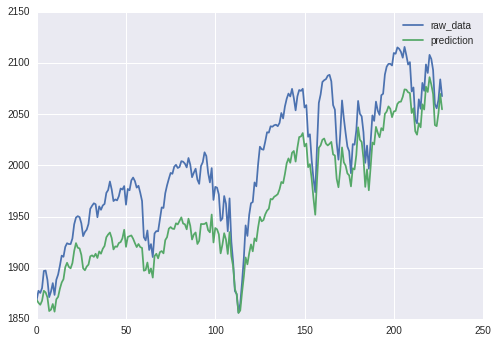

In [31]:
import time

T = len(input_data)
N_middle = T
esn = ESN(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data))
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, 
                           target_data=target_data, start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.0408661365509


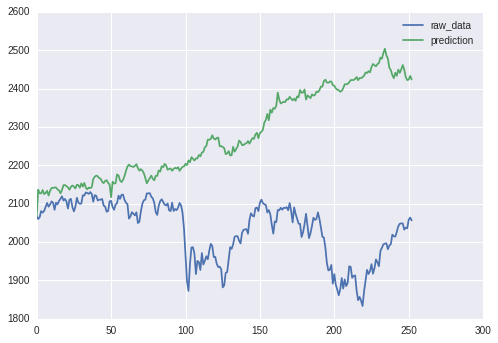

In [34]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 0.13945889473


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


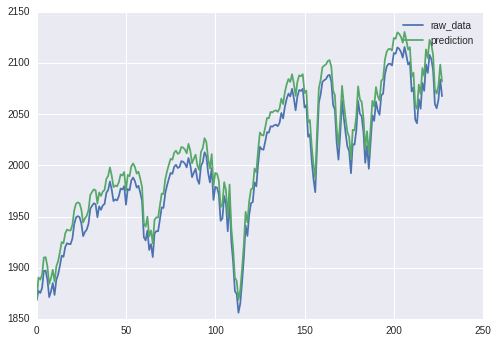

In [35]:
import time

T = len(input_data)
N_middle = T
esn = ESN(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data))
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, 
                           target_data=target_data, start_time=start_time, sig=1.0)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.0419690608978


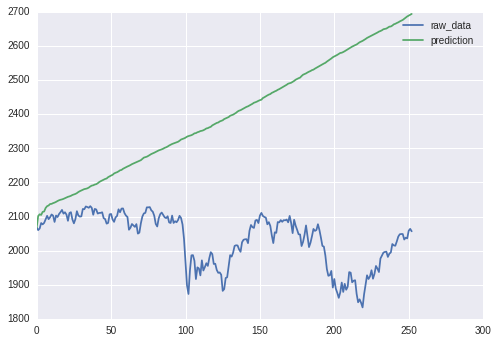

In [36]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

It might be better to use sig=1.0e-2

learning_time: 7.12644004822


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


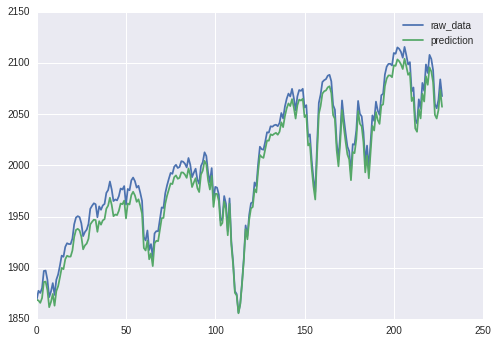

In [43]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data))
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, 
                           target_data=target_data, start_time=start_time, sig=0.01)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.593460083008


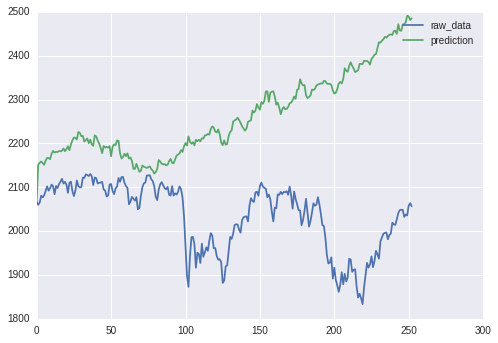

In [44]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 48.6981217861


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


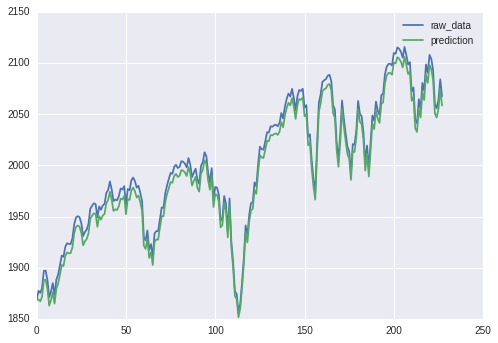

In [45]:
import time

T = len(input_data)
N_middle = T * 10
esn = ESN(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data))
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, 
                           target_data=target_data, start_time=start_time, sig=0.01)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 2.3585498333


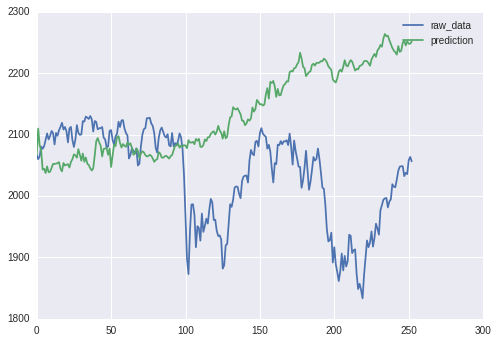

In [46]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

# Let's change the learning time

In [51]:
import quandl 

start_date="2013-04-01"
end_date="2015-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
sp = quandl.get("YAHOO/INDEX_GSPC", start_date=start_date, end_date=end_date)
target_data = np.array(sp['Open'])

start_date="2015-04-01"
end_date="2016-04-01"
input_data_pred, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
sp = quandl.get("YAHOO/INDEX_GSPC", start_date=start_date, end_date=end_date)
target_data_pred = np.array(sp['Open'])

learning_time: 0.749875068665


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


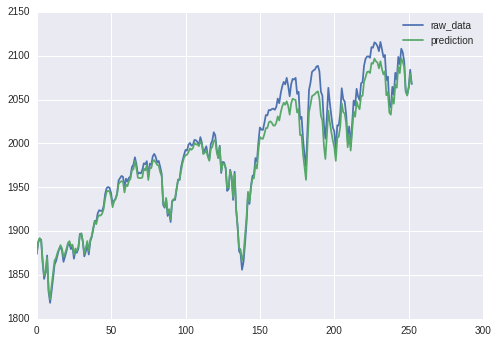

In [52]:
import time

T = len(input_data)
N_middle = T
esn = ESN(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data))
start_time = 0.5 * T

st = time.time()
output_data = esn.learning(input_data=input_data, 
                           target_data=target_data, start_time=start_time, sig=0.01)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.107196092606


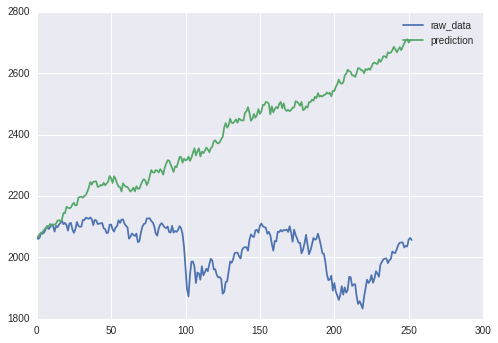

In [53]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 51.1423768997


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


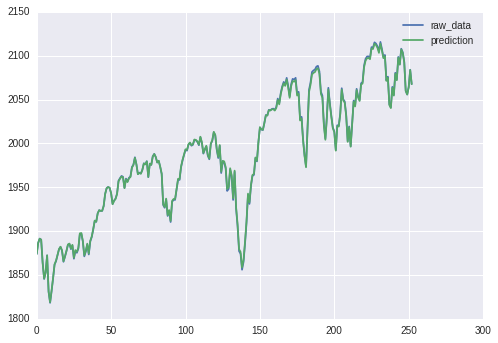

In [54]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data))
start_time = 0.5 * T

st = time.time()
output_data = esn.learning(input_data=input_data, 
                           target_data=target_data, start_time=start_time, sig=0.01)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 2.19278597832


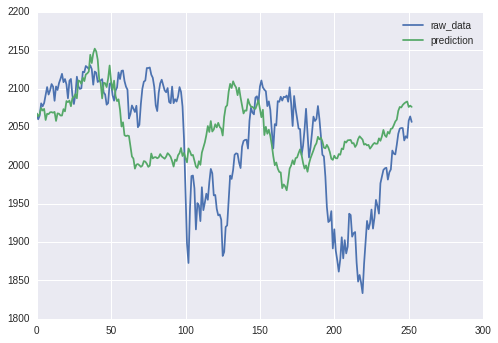

In [55]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 50.863740921


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


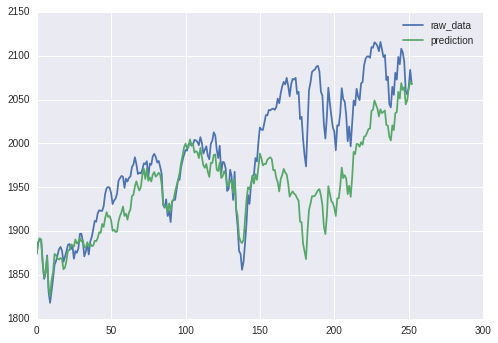

In [56]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data))
start_time = 0.5 * T

st = time.time()
output_data = esn.learning(input_data=input_data, 
                           target_data=target_data, start_time=start_time, sig=0)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 2.17542004585


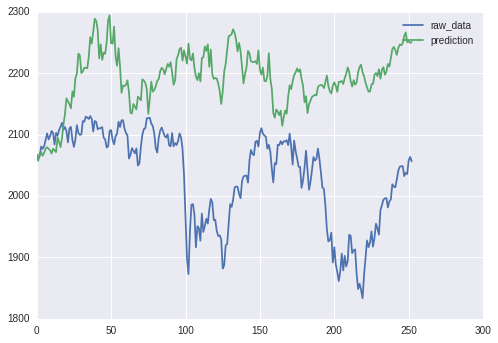

In [57]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

# Try with normalization

In [103]:
class ESN2(object):
    
    def __init__(
            self, N_in, N_middle, N_out, 
            activation=np.tanh, 
            dense=0.15, scale=0.8, alpha=1.0, 
            W_in=None, W_middle=None, W_out=None
        ):
        """shape feature
        Args:
            N_in (int): The dimention of input
            N_middle (int): the number of hidden nodes
            N_out (int): the dimention of output
            activation (lambda): activation function of middle layer
            dense (float): the degree of sparsity of W_in and W_middle
            scale (float): the scale of W_middle
            alpha (float): initialization for W_in and W_middle
                uniform_dist [-alpha, alpha]
            W_* (np.array): weitght for each layer
        """
        
        self.N_in = N_in
        self.N_out = N_out
        self.N_middle = N_middle
        self.activation = activation
        self.middle = np.zeros(shape=self.N_middle)
    
        if W_middle is None:
            # the number of non-zero elements
            num_w = int(N_middle * N_middle * dense)
            W_middle = np.zeros(shape=(N_middle, N_middle))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_middle)
                while(W_middle[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_middle[row][col] = u
            #normalization
            eig_max = np.max(np.abs(np.linalg.eigvals(W_middle)))
            W_middle = W_middle / eig_max * scale
        self.W_middle = W_middle
        
        if W_in is None:
            # the number of non-zero elements
            num_w = int(N_in * N_middle  * dense)
            W_in = np.zeros(shape=(N_middle, N_in))
            for i in xrange(num_w):
                row = np.random.randint(low=0, high=N_middle)
                col = np.random.randint(low=0, high=N_in)
                while(W_in[row][col] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                    col = np.random.randint(low=0, high=N_in)
                u = np.random.uniform(low=-alpha, high=alpha)
                W_in[row][col] = u
            # bias
            num_b = int(N_middle  * dense)
            bias_in = np.zeros(shape=N_middle)
            for i in xrange(num_b):
                row = np.random.randint(low=0, high=N_middle)
                while(bias_in[row] != 0):
                    row = np.random.randint(low=0, high=N_middle)
                u = np.random.uniform(low=-alpha, high=alpha)
                bias_in[row] = u
            W_in = np.c_[bias_in, W_in]
        self.W_in = W_in
        
    def normalization(self, data):
        dev = np.sqrt(np.var(data, axis=0))
        mean = np.mean(data, axis=0)
        return (data - mean) / dev, mean, dev
        
        
    def learning(self, input_data, target_data, start_time, L2=1.0e-2, sig=1.0e-2):
        # use log ratio data
        df_input_tilde = np.log(input_data[1:] / input_data[:-1])
        df_input, mean_ipt, dev_ipt = self.normalization(df_input_tilde)
        df_target_tilde = np.log(target_data[1:] / target_data[:-1])
        df_target, mean_tgt, dev_tgt = self.normalization(df_target_tilde)
        #keep deviance and mean for prediction
        self.input_mean = mean_ipt
        self.input_dev = dev_ipt
        self.output_mean = mean_tgt
        self.output_dev = dev_tgt
        
        N_data = len(df_input)
        Y = []
        X = []
        # initalization
        middle = np.zeros(shape=self.N_middle)
        output = np.zeros(shape=self.N_out)
        middle_data = []
        for i in xrange(N_data):
            new_m = self.activation(
                np.dot(self.W_in, np.r_[1.0, df_input[i]])\
                + np.dot(self.W_middle, middle)
                )\
                + sig * np.random.randn(self.N_middle)
            
            if i >= start_time:
                # minimize ||Y - X * W.T|| ** 2+ L2 * ||W|| ** 2
                Y.append(df_target[i])
                X.append(np.r_[1.0, df_input[i], new_m])
            
            middle = new_m  
            middle_data.append(middle)
           
        Y = np.array(Y)
        X = np.array(X)
        #keep middle data for predcition
        self.middle = middle
                                    
        if L2 == 0:
            X_inv = np.real(np.linalg.pinv(X.T))
        else:
            X_inv = np.dot(X, np.linalg.inv(L2 * np.identity(self.N_in + self.N_middle + 1) + np.dot(X.T, X)))
        self.W_out = np.dot(Y.T, X_inv)
        pre_out = np.c_[np.ones(N_data), df_input, middle_data]
        modified_out = self.output_dev * np.dot(self.W_out, pre_out[start_time:].T).T + self.output_mean
        accumulated_price = np.cumprod(np.exp(modified_out))
        learned_data = target_data[start_time] * np.r_[1.0, accumulated_price]
        return learned_data
    
    def predict(self, input_data, sig=0):
        df_input_tilde = np.log(input_data[1:] / input_data[:-1])
        df_input = (df_input_tilde - self.input_mean) / self.input_dev
        N_data = len(df_input)
        #initalization
        middle = self.middle.copy()
        output_data = []
        for i in xrange(N_data):
            new_m = self.activation(np.dot(self.W_in, np.r_[1.0, df_input[i]]) \
                                    + np.dot(self.W_middle, middle)) + sig*np.random.randn(self.N_middle)
            output = np.dot(self.W_out, np.r_[1.0, df_input[i], new_m])
            middle = new_m
            output_data.append(output)
        output_data_tilde = np.exp((self.output_dev * np.array(output_data) + self.output_mean).T)
        accumulated_price = np.cumprod(output_data_tilde)
        return np.r_[1.0, accumulated_price]

learning_time: 0.889991044998


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:120: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:122: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


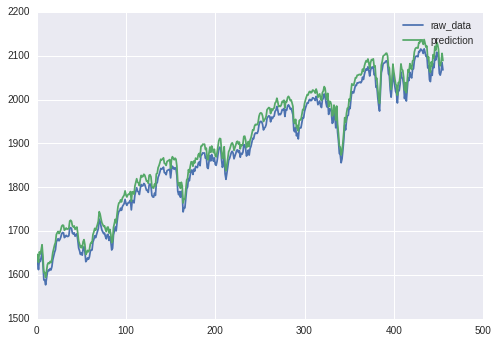

In [108]:
import time

T = len(input_data)
N_middle = T
esn = ESN2(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data))
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, 
                           target_data=target_data, start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.108339071274


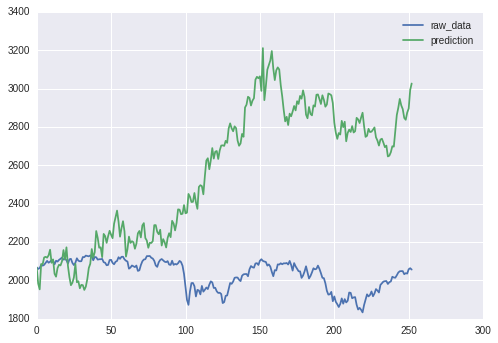

In [109]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 54.6848890781


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:120: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:122: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


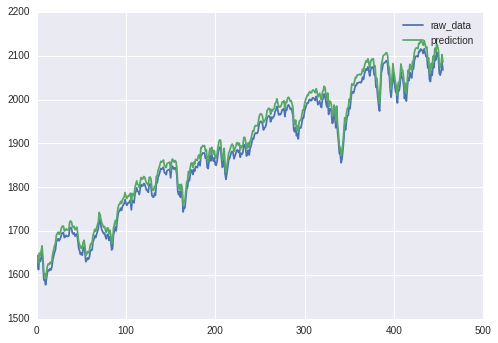

In [110]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN2(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data))
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, 
                           target_data=target_data, start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 2.20918703079


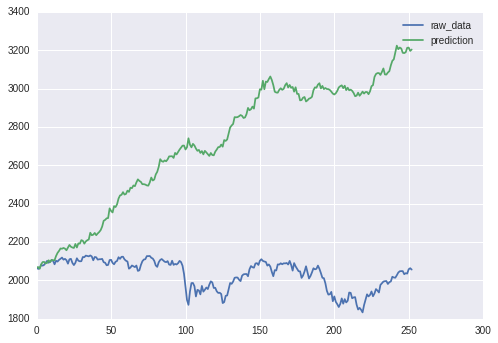

In [111]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 54.7362771034


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:120: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:122: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


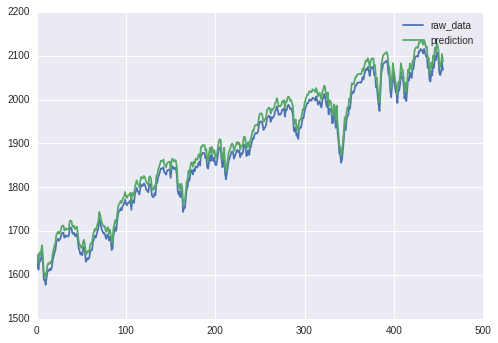

In [112]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN2(N_in=len(input_data[0]), N_middle=N_middle, N_out=len(target_data))
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, 
                           target_data=target_data, start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 2.23473501205


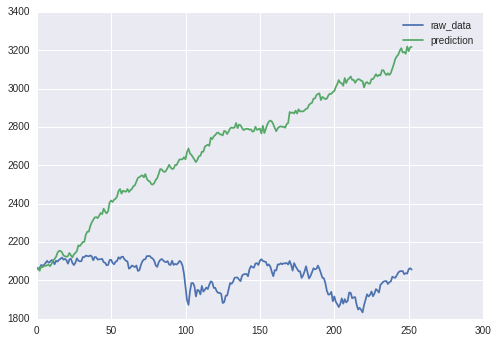

In [115]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

# use more data

In [148]:
energy = ["PTR", "XOM", "CVX", "RDS-A", "BP", "TOT", "SLB", "KMI", "COP", "CEO"]
financial = ["WFC", "JPM", "HSBC", "BAC", "C", "SAN", "MTU", "RY", "WBK", "TD"]
healthcare = ["NVS", "JNJ", "PFE", "MRK", "GILD", "SNY", "AMGN", "NVO", "GSK", "UNH"]
buisiness = ["ACN", "LMT", "CNI", "FDX", "DAL", "CSX", "AAL", "CP", "NSC", "NOC"]
telecom = ["CHL", "VZ", "T", "VOD", "NTT", "AMX", "CHA", "BT", "CHU", "ORAN"]
hardware = ["AAPL", "ORCL", "IBM", "INTC", "CSCO", "TSM", "QCOM", "HPQ", "TXN", "EMC"]
software = ["MSFT", "GOOGL", "FB", "BIDU", "EBAY", "SAP", "CRM", "YHOO", "VMW", "ADBE"]
industrial = ["GE", "V", "MA", "UTX", "MMM", "BA", "UNP", "UPS", "HON", "DHR"]
manufacturing = ["TM", "HMC", "F", "GM", "JCI", "TSLA", "TTM", "CMI", "DLPH", "MGA"]
consumer = ["PG", "BUD", "KO", "PEP", "UL", "PM", "BTI", "MO", "ABEV", "DEO"]
diversified = ["BRK-A", "BRK-B", "UTX", "BC", "RTN", "OLN", "ITT", "MSBHY", "KWHIY", "ABB"]
retailing = ["WMT", "AMZN", "HD", "MCD", "NKE", "SBUX", "CVS", "WBA", "PCLN", "COST"]

input_list = energy + financial + healthcare + buisiness + telecom\
+ hardware + software + industrial + manufacturing + consumer + diversified + retailing

In [162]:
from yahoo_finance import Share

def get_data_by_key(key, data):
    data_it = iter(data)
    return_data = []
    flag = True
    for d in data_it:
        return_data.append(d[key])
        
    return np.array(return_data)

def get_data_by_list(name_list, start_date, end_date, data_type="Open"):
    share_list = []
    for name in name_list:
        share_list.append(Share(name))
    
    stock_data_list = []
    date = []
    flag = True
    N_data = 0
    for idx, share in enumerate(share_list):
        name = name_list[idx]
        hist_data = share.get_historical(start_date=start_date, end_date=end_date)
        stock_data = map(float, get_data_by_key(key=data_type, data=hist_data))
        date.append(get_data_by_key(key='Date', data=hist_data))
        stock_data_list.append(stock_data)
        N_data = len(stock_data)
        assert N_data != 0, "%s data is broken" % name
        if idx != 0:
            assert pre_N_data == N_data, "%s data is broken" % name
        pre_N_data = N_data
    return np.array(stock_data_list).T, date

In [174]:
import quandl 

start_date="2014-04-01"
end_date="2015-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
sp = quandl.get("YAHOO/INDEX_GSPC", start_date=start_date, end_date=end_date)
target_data = np.array(sp['Close'])

start_date="2015-04-01"
end_date="2016-04-01"
input_data_pred, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
sp = quandl.get("YAHOO/INDEX_GSPC", start_date=start_date, end_date=end_date)
target_data_pred = np.array(sp['Close'])

"SNO"　data is broken!

learning_time: 0.223308086395


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


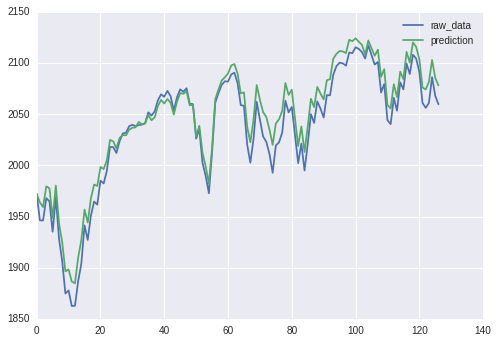

In [175]:
import time

T = len(input_data)
N_middle = T
esn = ESN(N_in=len(input_data[0]), N_middle=N_middle, N_out=1)
start_time = 0.5 * T

st = time.time()
output_data = esn.learning(input_data=input_data, 
                           target_data=target_data, start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.0503749847412


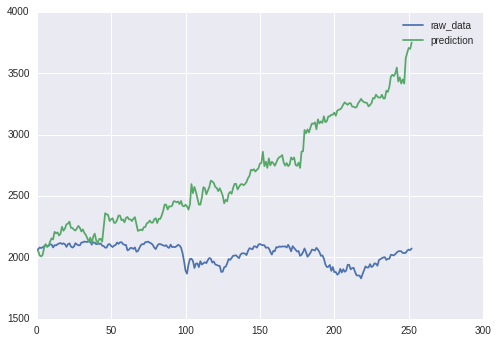

In [176]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

learning_time: 7.90893220901


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


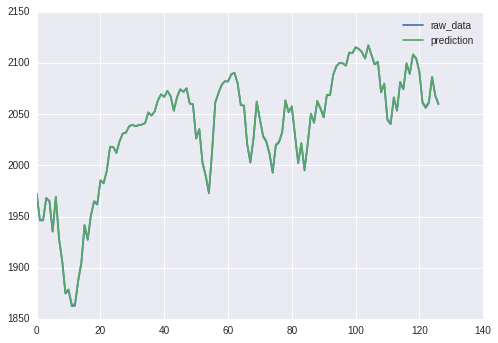

In [177]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN(N_in=len(input_data[0]), N_middle=N_middle, N_out=1)
start_time = 0.5 * T

st = time.time()
output_data = esn.learning(input_data=input_data, 
                           target_data=target_data, start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.59969997406


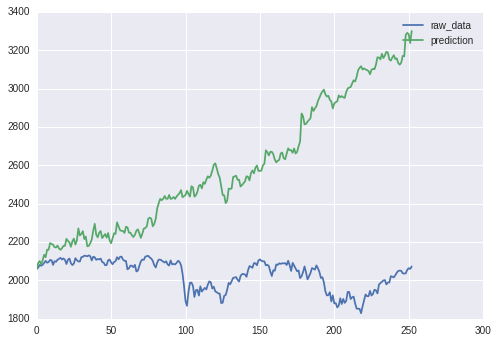

In [178]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

# Add More Data!

In [186]:
energy = ["PTR", "XOM", "CVX", "RDS-A", "BP", "TOT", "SLB", "KMI", "COP", "CEO", 
          "E", "STO", "EDPR.LS", "OXY", "PBR", "EOG", "APC", "SU", "ENB", "PSX", "HAL", "WMB"]
financial = ["WFC", "JPM", "HSBC", "BAC", "C", "SAN", "MTU", "RY", "WBK", "TD", "GS", 
             "LYG", "AXP", "AIG", "MS", "ITUB", "BCS", "BBVA"]
healthcare = ["NVS", "JNJ", "PFE", "MRK", "GILD", "SNY", "AMGN", "NVO", "GSK", "UNH",
             "MDT", "BMY", "ABBV", "CELG", "BIIB", "AZN", "LLY", "ABT", "AGN", "VRX", "TEVA",
             "TMO", "SHPG", "REGN"]
buisiness = ["ACN", "LMT", "CNI", "FDX", "DAL", "CSX", "AAL", "CP", "NSC", "NOC", "LUV"]
telecom = ["CHL", "VZ", "T", "VOD", "NTT", "AMX", "CHA", "BT", "CHU", "ORAN", "BCE",
           "CHT", "SKM", "TI", "TU", "S", "TLK", "DUK", "NGG", "NEE", "D", "SO", "EXC", "KEP",
          "AEP", "SRE", "PCG", "HNP", "PPL", "PEG", "EIX", "ETP", "ED", "ENI", "XEL", "ES", "FE"]
hardware = ["AAPL", "ORCL", "IBM", "INTC", "CSCO", "TSM", "QCOM", "HPQ", "TXN", "EMC",
           "CAJ", "ASML", "ERIC", "SNE", "AVGO", "MU", "GLW", "BRCM", "NXPI", "NOK",
           "AMAT", "WDC", "WIT", "ADI", "STX", "APH"]
software = ["MSFT", "GOOGL", "FB", "BIDU", "EBAY", "SAP", "CRM", "YHOO", "VMW",
            "ADBE", "CTSH", "INFY", "INTU", "LNKD", "TWTR", "RHT", "NTES", "CHKP", 
            "CA", "ADSK", "AKAM", "NVDA"]
industrial = ["GE", "V", "MA", "UTX", "MMM", "BA", "UNP", "UPS", "HON", "DHR", "CAT", 
              "ABB", "GD", "ADP", "EMR", "ITW", "ECL", "PCP", "TEL", "PCAR", "WM"]
manufacturing = ["TM", "HMC", "F", "GM", "JCI", "TSLA", "TTM", "CMI", "DLPH", "MGA",
                "CMI", "DLPH", "MGA", "GPC", "BWA", "HOG", "ALV", "HAR", "LEA", "LKQ", 
                 "WBC", "GT", "FCAU", "NSANY", "VOW3.DE", "NAV", "005380.KS"]
consumer = ["PG", "BUD", "KO", "PEP", "UL", "PM", "BTI", "MO", "ABEV", "DEO", "MDLZ",
            "CL", "MON", "MCK", "KMB", "WHR", "DIS", "CMCSA", "FOXA", "TWX", "TWC",
           "DISH", "CBS", "DISCA", "TV", "CHTR", "LVNTA", "QVCA", "OMC", "NLSN", 
           "PSO", "LMCA", "SJR", "NFLX"]
diversified = ["BRK-A", "BRK-B", "UTX", "BC", "RTN", "OLN", "ITT", "MSBHY", "KWHIY", 
               "ABB", "IEP", "GE"]
retailing = ["WMT", "AMZN", "HD", "MCD", "NKE", "SBUX", "CVS", "WBA", "PCLN", "COST", 
            "TGT", "TJX", "LVS", "YUM", "CCL", "LUX", "DG", "M", "AZO", "ROST", "CMG", "GPS", 
            "DLTR", "RCL", "KSS", "HOT", "JWN"]

input_list = energy + financial + healthcare + buisiness + telecom\
+ hardware + software + industrial + manufacturing + consumer + diversified + retailing
print (len(input_list))

281


In [215]:
from yahoo_finance import Share

def get_data_by_key(key, data):
    data_it = iter(data)
    return_data = []
    flag = True
    for d in data_it:
        return_data.append(d[key])
        
    return np.array(return_data)

def get_data_by_list(name_list, start_date, end_date, data_type="Open"):
    share_list = []
    for name in name_list:
        share_list.append(Share(name))
    
    stock_data_list = []
    date = []
    flag = True
    fail_name_list = []
    for idx, share in enumerate(share_list):
        name = name_list[idx]
        hist_data = share.get_historical(start_date=start_date, end_date=end_date)
        stock_data = map(float, get_data_by_key(key=data_type, data=hist_data))
        date.append(get_data_by_key(key='Date', data=hist_data))
        stock_data_list.append(np.array(stock_data))
        N_data = len(stock_data)
        if idx == 0:
            pre_N_data = N_data
        if N_data == 0:
            fail_name_list.append(name)
        else:
            if pre_N_data != N_data:
                fail_name_list.append(name)
            else:
                pre_N_data = N_data
    print ("fail_name_list: ", fail_name_list)
    return np.array(stock_data_list).T, date

In [216]:
import quandl 
import time 

print ("Started!!")

st = time.time()
start_date="2014-04-01"
end_date="2015-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
sp = quandl.get("YAHOO/INDEX_GSPC", start_date=start_date, end_date=end_date)
target_data = np.array(sp['Open'])
elapsed = time.time() - st
print ("time for getting training_data:", elapsed)

st = time.time()
start_date="2015-04-01"
end_date="2016-04-01"
input_data_pred, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
sp = quandl.get("YAHOO/INDEX_GSPC", start_date=start_date, end_date=end_date)
target_data_pred = np.array(sp['Open'])
elapsed = time.time() - st
print ("time for getting test_data:", elapsed)

Started!!
fail_name_list:  ['EDPR.LS', 'VOW3.DE', '005380.KS']
time for getting training_data: 625.405124187
fail_name_list:  ['EDPR.LS', 'BRCM', 'PCP', 'VOW3.DE', '005380.KS']
time for getting test_data: 718.314601183


'SNO', 'UBS', 'JD', 'PYPL', 'KHC', 'VIVA', 'PYPL', 'EDPR.LS', 'VOW3.DE', '005380.KS', 'BRCM', 'PCP' data are broken!

In [217]:
energy = ["PTR", "XOM", "CVX", "RDS-A", "BP", "TOT", "SLB", "KMI", "COP", "CEO", 
          "E", "STO", "OXY", "PBR", "EOG", "APC", "SU", "ENB", "PSX", "HAL", "WMB"]
financial = ["WFC", "JPM", "HSBC", "BAC", "C", "SAN", "MTU", "RY", "WBK", "TD", "GS", 
             "LYG", "AXP", "AIG", "MS", "ITUB", "BCS", "BBVA"]
healthcare = ["NVS", "JNJ", "PFE", "MRK", "GILD", "SNY", "AMGN", "NVO", "GSK", "UNH",
             "MDT", "BMY", "ABBV", "CELG", "BIIB", "AZN", "LLY", "ABT", "AGN", "VRX", "TEVA",
             "TMO", "SHPG", "REGN"]
buisiness = ["ACN", "LMT", "CNI", "FDX", "DAL", "CSX", "AAL", "CP", "NSC", "NOC", "LUV"]
telecom = ["CHL", "VZ", "T", "VOD", "NTT", "AMX", "CHA", "BT", "CHU", "ORAN", "BCE",
           "CHT", "SKM", "TI", "TU", "S", "TLK", "DUK", "NGG", "NEE", "D", "SO", "EXC", "KEP",
          "AEP", "SRE", "PCG", "HNP", "PPL", "PEG", "EIX", "ETP", "ED", "ENI", "XEL", "ES", "FE"]
hardware = ["AAPL", "ORCL", "IBM", "INTC", "CSCO", "TSM", "QCOM", "HPQ", "TXN", "EMC",
           "CAJ", "ASML", "ERIC", "SNE", "AVGO", "MU", "GLW", "NXPI", "NOK",
           "AMAT", "WDC", "WIT", "ADI", "STX", "APH"]
software = ["MSFT", "GOOGL", "FB", "BIDU", "EBAY", "SAP", "CRM", "YHOO", "VMW",
            "ADBE", "CTSH", "INFY", "INTU", "LNKD", "TWTR", "RHT", "NTES", "CHKP", 
            "CA", "ADSK", "AKAM", "NVDA"]
industrial = ["GE", "V", "MA", "UTX", "MMM", "BA", "UNP", "UPS", "HON", "DHR", "CAT", 
              "ABB", "GD", "ADP", "EMR", "ITW", "ECL", "TEL", "PCAR", "WM"]
manufacturing = ["TM", "HMC", "F", "GM", "JCI", "TSLA", "TTM", "CMI", "DLPH", "MGA",
                "CMI", "DLPH", "MGA", "GPC", "BWA", "HOG", "ALV", "HAR", "LEA", "LKQ", 
                 "WBC", "GT", "FCAU", "NSANY", "NAV"]
consumer = ["PG", "BUD", "KO", "PEP", "UL", "PM", "BTI", "MO", "ABEV", "DEO", "MDLZ",
            "CL", "MON", "MCK", "KMB", "WHR", "DIS", "CMCSA", "FOXA", "TWX", "TWC",
           "DISH", "CBS", "DISCA", "TV", "CHTR", "LVNTA", "QVCA", "OMC", "NLSN", 
           "PSO", "LMCA", "SJR", "NFLX"]
diversified = ["BRK-A", "BRK-B", "UTX", "BC", "RTN", "OLN", "ITT", "MSBHY", "KWHIY", 
               "ABB", "IEP", "GE"]
retailing = ["WMT", "AMZN", "HD", "MCD", "NKE", "SBUX", "CVS", "WBA", "PCLN", "COST", 
            "TGT", "TJX", "LVS", "YUM", "CCL", "LUX", "DG", "M", "AZO", "ROST", "CMG", "GPS", 
            "DLTR", "RCL", "KSS", "HOT", "JWN"]

input_list = energy + financial + healthcare + buisiness + telecom\
+ hardware + software + industrial + manufacturing + consumer + diversified + retailing
print (len(input_list))

276


In [218]:
import quandl 
import time 

print ("Started!!")

st = time.time()
start_date="2014-04-01"
end_date="2015-04-01"
input_data, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
sp = quandl.get("YAHOO/INDEX_GSPC", start_date=start_date, end_date=end_date)
target_data = np.array(sp['Open'])
elapsed = time.time() - st
print ("time for getting training_data:", elapsed)

st = time.time()
start_date="2015-04-01"
end_date="2016-04-01"
input_data_pred, date = get_data_by_list(input_list, start_date=start_date, end_date=end_date) 
sp = quandl.get("YAHOO/INDEX_GSPC", start_date=start_date, end_date=end_date)
target_data_pred = np.array(sp['Open'])
elapsed = time.time() - st
print ("time for getting test_data:", elapsed)

Started!!
fail_name_list:  []
time for getting training_data: 620.772111893
fail_name_list:  []
time for getting test_data: 614.669239044


learning_time: 12.3775889874


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


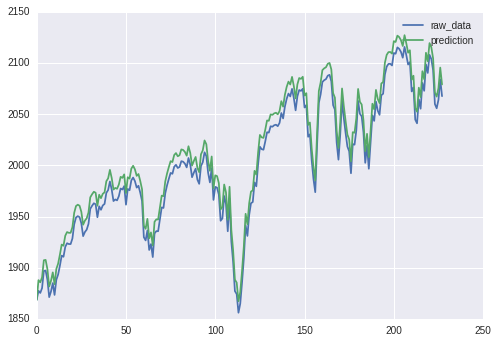

In [221]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN(N_in=len(input_data[0]), N_middle=N_middle, N_out=1)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, 
                           target_data=target_data, start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st


print ("learning_time:", elapsed)
plt.plot(target_data[start_time:], label="raw_data")
plt.plot(output_data, label="prediction")
plt.legend()

prediction time: 0.765466928482


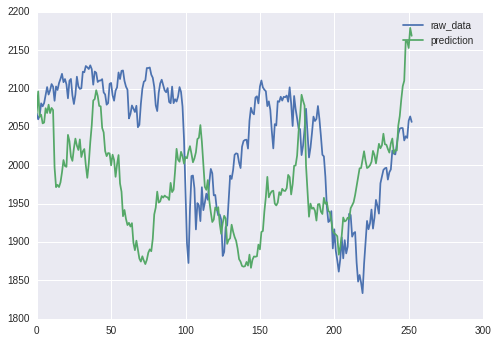

In [222]:
st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st

print ("prediction time:", elapsed)
plt.plot(target_data_pred, label="raw_data")
plt.plot(output_data_pred, label="prediction")
plt.legend()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


learning_time: 11.9508678913
prediction time: 0.758254051208


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


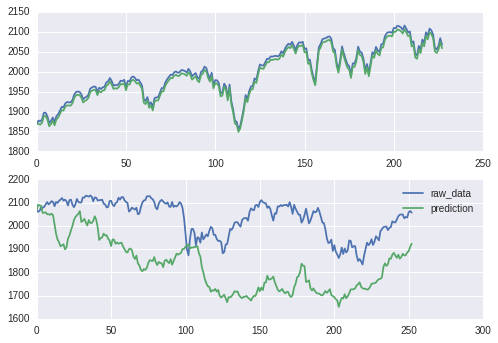

In [225]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.9, dense=0.15)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, 
                           target_data=target_data, start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st
print ("learning_time:", elapsed)

st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st
print ("prediction time:", elapsed)

fig = plt.figure()

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(target_data[start_time:], label="raw_data")
ax1.plot(output_data, label="prediction")
plt.legend()

ax2.plot(target_data_pred, label="raw_data")
ax2.plot(output_data_pred, label="prediction")
plt.legend()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


learning_time: 12.1809191704
prediction time: 0.783411979675


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


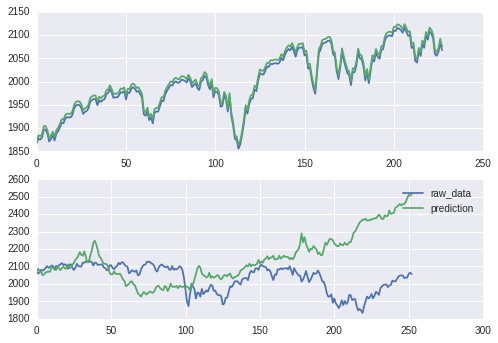

In [226]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.99, dense=0.15)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, 
                           target_data=target_data, start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st
print ("learning_time:", elapsed)

st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st
print ("prediction time:", elapsed)

fig = plt.figure()

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(target_data[start_time:], label="raw_data")
ax1.plot(output_data, label="prediction")
plt.legend()

ax2.plot(target_data_pred, label="raw_data")
ax2.plot(output_data_pred, label="prediction")
plt.legend()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


learning_time: 12.0471241474
prediction time: 0.723648786545


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


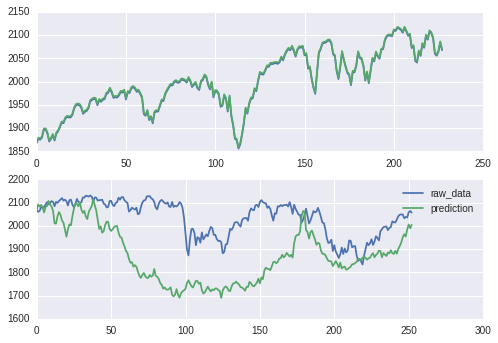

In [227]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.8, dense=0.3)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, 
                           target_data=target_data, start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st
print ("learning_time:", elapsed)

st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st
print ("prediction time:", elapsed)

fig = plt.figure()

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(target_data[start_time:], label="raw_data")
ax1.plot(output_data, label="prediction")
plt.legend()

ax2.plot(target_data_pred, label="raw_data")
ax2.plot(output_data_pred, label="prediction")
plt.legend()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


learning_time: 12.028783083
prediction time: 0.7877368927


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


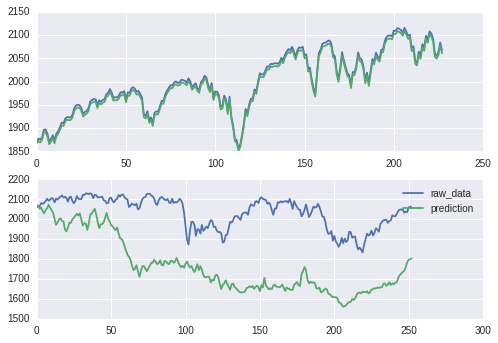

In [228]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.8, dense=0.5)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, 
                           target_data=target_data, start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st
print ("learning_time:", elapsed)

st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st
print ("prediction time:", elapsed)

fig = plt.figure()

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(target_data[start_time:], label="raw_data")
ax1.plot(output_data, label="prediction")
plt.legend()

ax2.plot(target_data_pred, label="raw_data")
ax2.plot(output_data_pred, label="prediction")
plt.legend()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


learning_time: 12.1794490814
prediction time: 0.825560808182


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


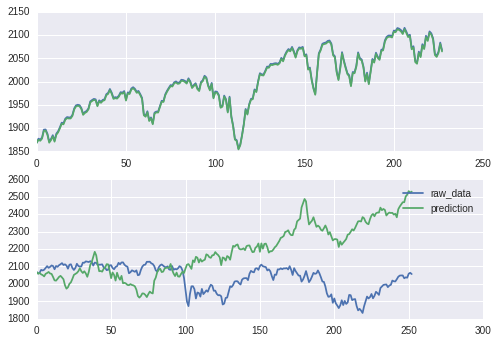

In [229]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.8, dense=0.8)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, 
                           target_data=target_data, start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st
print ("learning_time:", elapsed)

st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st
print ("prediction time:", elapsed)

fig = plt.figure()

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(target_data[start_time:], label="raw_data")
ax1.plot(output_data, label="prediction")
plt.legend()

ax2.plot(target_data_pred, label="raw_data")
ax2.plot(output_data_pred, label="prediction")
plt.legend()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:108: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


learning_time: 11.5602300167
prediction time: 0.69633603096


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


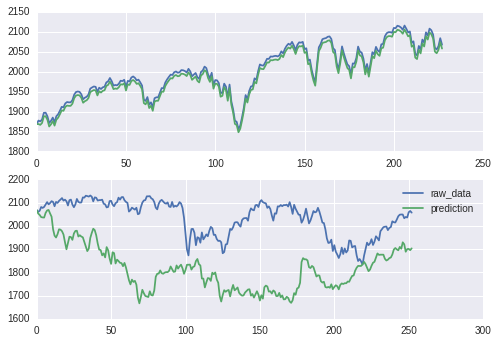

In [232]:
import time

T = len(input_data)
N_middle = T * 5
esn = ESN(N_in=len(input_data[0]), N_middle=N_middle, N_out=1, scale=0.8, dense=1.0)
start_time = 0.1 * T

st = time.time()
output_data = esn.learning(input_data=input_data, 
                           target_data=target_data, start_time=start_time, sig=1.0e-2)
elapsed = time.time() - st
print ("learning_time:", elapsed)

st = time.time()
output_data_pred = target_data_pred[0] * esn.predict(input_data_pred)
elapsed = time.time() - st
print ("prediction time:", elapsed)

fig = plt.figure()

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(target_data[start_time:], label="raw_data")
ax1.plot(output_data, label="prediction")
plt.legend()

ax2.plot(target_data_pred, label="raw_data")
ax2.plot(output_data_pred, label="prediction")
plt.legend()